In [1]:
from ase import Atoms
from ase.build import stack
from abtem import show_atoms
from matplotlib import pyplot as plt
from ase.visualize import view
from ase.visualize.plot import plot_atoms
import numpy as np
from ase.io import read, write
import sys
import hyperspy.api as hs
import atomap.api as am
sys.path.append("../Functions")
from GS_waves import (
    defocus_stack,
    select_freq_range,
    select_defocus_profile
)
from abtem.waves import PlaneWave
from matplotlib import pyplot as plt
from tqdm import tqdm
from lmfit import Model
import circle_fit as cf
from Defocus_circle import find_angle
from Column_matching import (
    match_parameters_Bessel,
    propagation_Bessel,
    inv_Bessel,
    Bessel_transform
    )
from sklearn.linear_model import LinearRegression

def select_column(ew, peak_sites, distance, index):
    n_col, n_row = peak_sites[index,:]
    dist = int(distance)
    lx, ux = n_col - dist, n_col + dist
    ly, uy = n_row - dist, n_row + dist
    ew_sel = ew[ly:uy, lx:ux]
    return ew_sel

def find_background(exitwave, threshold=0.001):
    sel_grad = np.abs(np.gradient(exitwave)[0])**2 + np.abs(np.gradient(exitwave)[1])**2
    bg = exitwave[np.where(sel_grad<threshold)]
    return np.mean(bg)

def Gaussian_function(k, a_re, a_im, b_re, b_im, c_re, c_im):
    theta = -b_im * k**2
    y_re = c_re + np.exp(-b_re * k**2) * (a_re*np.cos(theta) - a_im*np.sin(theta))
    y_im = c_im + np.exp(-b_re * k**2) * (a_re*np.sin(theta) + a_im*np.cos(theta))
    return y_re + 1j*y_im

def Gaussian_in_focus(k, a_re, a_im, b, c_re, c_im):
    y_re = c_re + a_re * np.exp(-b * k**2)
    y_im = c_im + a_im * np.exp(-b * k**2)
    return y_re + 1j*y_im

def Gaussian_fitting(profile, freq_data, freq_range):
    index_sel = np.where(np.logical_and(freq_data>=freq_range[0],
                                        freq_data<=freq_range[1]))
    #Step 1: fit line for the complex component
    fit_x = freq_data[index_sel]; fit_y = profile[index_sel]
    peak_complex = fit_y[0]
    re = np.real(fit_y).ravel().reshape(-1, 1)
    im = np.imag(fit_y).ravel()
    res = LinearRegression().fit(re, im)
    slope = res.coef_[0]; intercept = res.intercept_
    #Step 2: fit Gaussian function for the line
    X = (fit_x**2).reshape(-1, 1)
    y = np.log(np.abs(fit_y-intercept))
    res = LinearRegression().fit(X, y); k_init = -res.coef_[0]
    model = Model(Gaussian_function)
    params = model.make_params(a_re=np.real(peak_complex),
                               a_im=np.imag(peak_complex)-intercept,
                               b_re=0, b_im=intercept,
                               c_re=k_init, c_im=0)
    result = model.fit(fit_y, params, k=fit_x)
    return result

#define parameters and build unit cell
a = 2.0247 * 2
Al = Atoms("Al4", cell=[a, a, a], pbc=(1, 1, 1), 
           scaled_positions=[(0, 0, 0), (0, 0.5, 0.5), (0.5, 0, 0.5), (0.5, 0.5, 0)])
basecell = Al * (20, 20, 1)
supercell = basecell.copy()
for i in range(19, 0, -1):
    addcell = Al * (i, i, 1)
    addcell.cell = basecell.cell
    supercell = stack(supercell, addcell)
supercell.rotate(270, 'x')
supercell.center(vacuum=5)

In [2]:
energy = 300e3; sampling = 0.0656015
start = -10; end = 10; step=0.5
gmin = 0; gmax=1.5
ew = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(supercell).array),
                           gmin, gmax, sampling)

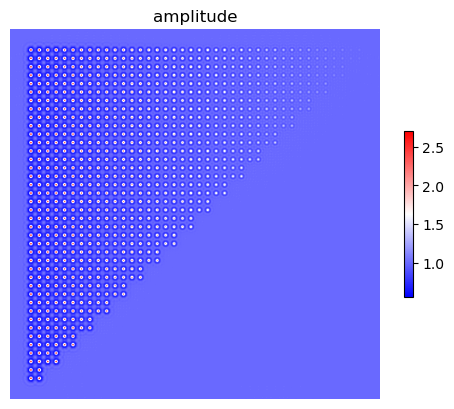

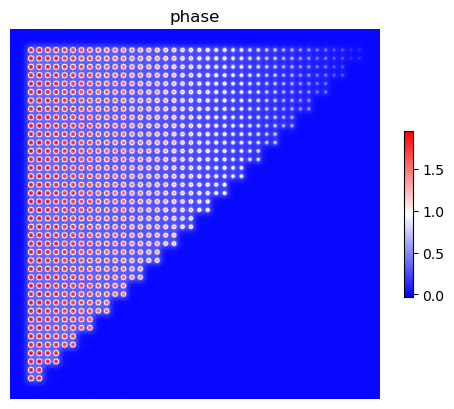

In [3]:
plt.imshow(np.abs(ew), cmap='bwr')
plt.colorbar(shrink=0.45)
plt.title("amplitude")
plt.axis("off")
plt.show()
plt.imshow(np.angle(ew), cmap='bwr')
plt.colorbar(shrink=0.45)
plt.title("phase")
plt.axis("off")
plt.show()

Center of mass:   0%|          | 0/840 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/840 [00:00<?, ?it/s]

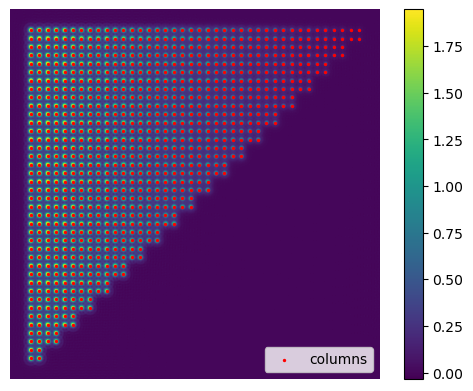

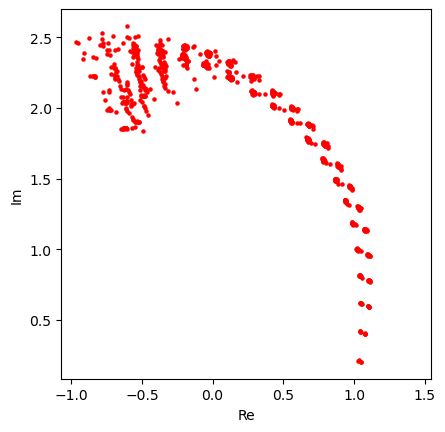

In [4]:
#Find peaks
signal = hs.signals.Signal2D(np.angle(ew))
peak = am.get_atom_positions(signal, pca=True, separation=15)
#Classify peaks
values = np.array([ew[int(peak[index, 1]), int(peak[index, 0])] for index in range(peak.shape[0])])
threshold = 0.15
index_sel = np.logical_and(np.angle(values) > threshold, np.abs(values-1) > threshold)
peak = peak[index_sel]
values = values[index_sel]
#Identify lattice
sublattice = am.Sublattice(peak,
                        image=np.abs(ew),
                        fix_negative_values=True)
sublattice.construct_zone_axes()
sublattice.find_nearest_neighbors()
sublattice.refine_atom_positions_using_center_of_mass()
sublattice.refine_atom_positions_using_2d_gaussian()
lattice = np.array(sublattice.zones_axis_average_distances)
distance = np.sqrt(lattice[0,0]**2 + lattice[0, 1]**2)
peak = sublattice.atom_positions
#Plot 1: mapping phase and peaks
plt.scatter(peak[:,0], peak[:,1],s=2, color='r', label='columns')
plt.legend()
plt.imshow(np.angle(ew))
plt.colorbar()
plt.axis("off")
plt.show()
#Plot 2: Argand plots of peaks
plt.scatter(np.real(values), np.imag(values), color='r', s=5)
plt.xlabel("Re")
plt.ylabel("Im")
plt.axis("square")
plt.show()

100%|██████████| 840/840 [06:56<00:00,  2.02it/s]


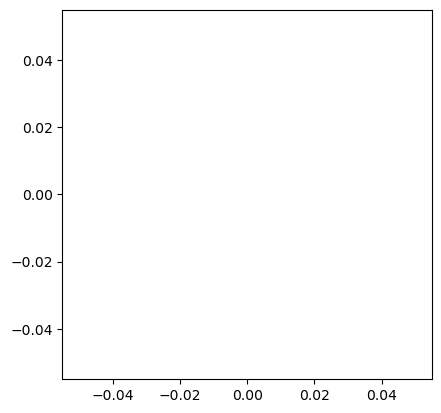

In [15]:
peak_sites = peak.astype(np.int64)
index_seq = np.array(range(values.shape[0]))
theta = np.linspace(0, 2*np.pi, 100)
length=50
circle_centers = []
bg_rec = []
peak_rec = []
position_rec = []
coeff_rec = []
for index in tqdm(index_seq):
    krange = np.linspace(gmin+0.01, gmax, length)
    ew_sel = select_column(ew, peak_sites, distance/2, index)
    #Step 1: match optimum background and position
    rx, ry, bg_amp, bg_pha = match_parameters_Bessel(ew_sel, sampling, 0.01, gmax)
    bg = bg_amp * np.exp(1j*bg_pha)
    bg_rec.append(bg)
    position_rec.append([rx, ry])
    #Step 2: extract components with optimum propagation
    results, components = Bessel_transform(ew_sel-bg, sampling, 0.01, gmax, 50, rx, ry)
    #peak_rec.append(components.ravel()[np.argmax(np.abs(components))])
    result = Gaussian_fitting(results,
                              krange,
                              [0.25, 1])
    coeff_rec.append(np.array(list(result.best_values.values())))
    #Step 3: Conduct Argand plot statistics
    m, n = components.shape
    a1, a2, b1, b2, c1, c2 = np.array(list(result.best_values.values()))
    peak_rec.append(a1+c1+1j*(a2+c2))
    results_fit = Gaussian_function(krange, a1, a2, b1, b2, c1, c2)
    #results_fit = Gaussian_in_focus(krange, a1, a2, b1, c1, c2) - c1 - 1j*c2
    components_fit = inv_Bessel(results_fit, m, n, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
    index = np.unravel_index(np.argmax(np.abs(components_fit)), components_fit.shape)
    peak_fitted = components_fit[index]
    #plt.scatter(np.real(peak_fitted), np.imag(peak_fitted), s=5, color='b')
    #plt.scatter(np.real(components_fit), np.imag(components_fit), s=5, color='b')
bg_rec = np.array(bg_rec)
peak_rec = np.array(peak_rec)
position_rec = np.array(position_rec)
coeff_rec = np.array(coeff_rec)
plt.axis("square")
plt.show()

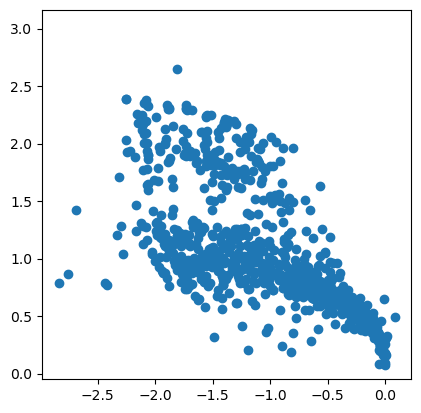

In [23]:
plt.scatter(coeff_rec[:,0]+coeff_rec[:,-2], coeff_rec[:,1]+coeff_rec[:,-1])
plt.axis("square")
plt.show()

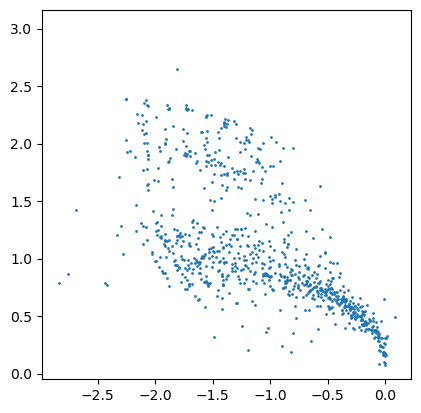

In [17]:
#plt.scatter(np.real(bg_rec), np.imag(bg_rec), s=1)
plt.scatter(np.real(peak_rec), np.imag(peak_rec), s=1)
plt.axis("square")
plt.show()

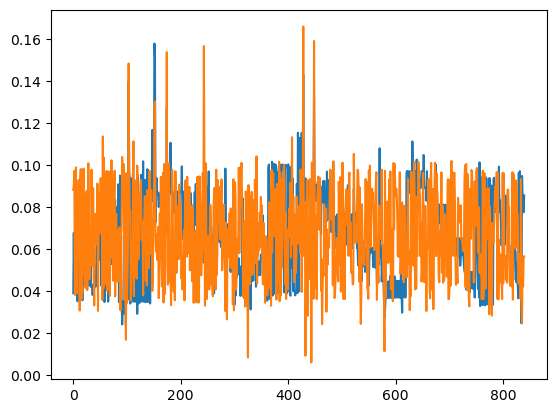

In [18]:
plt.plot(index_seq, position_rec[:,0], label='x')
plt.plot(index_seq, position_rec[:,1], label='y')
plt.show()

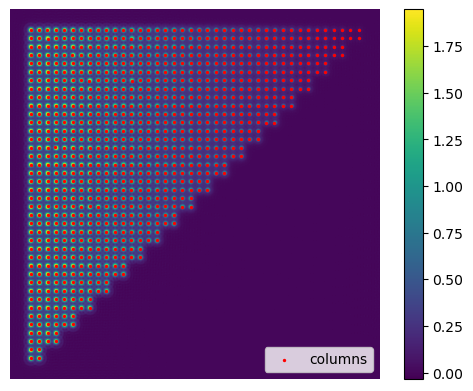

In [19]:
#peak_shift = peak - np.flip(position_rec, axis=1)/sampling
peak_shift = peak - position_rec/sampling
#Plot 1: mapping phase and peaks
#plt.scatter(peak[:,0], peak[:,1],s=2, color='b', label='columns')
plt.scatter(peak_shift[:,0], peak_shift[:,1],s=2, color='r', label='columns')
plt.legend()
plt.imshow(np.angle(ew))
plt.colorbar()
plt.axis("off")
plt.show()

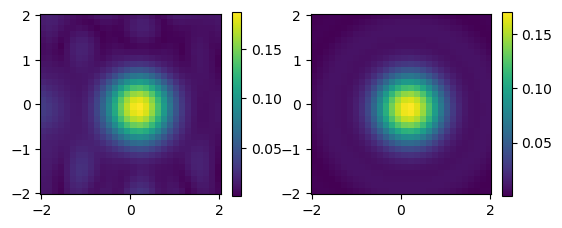

In [20]:
results, components = Bessel_transform(ew_sel-bg, sampling, 0.01, gmax, 50, rx, ry)
plt.subplot(1, 2, 1)
plt.imshow(np.abs(ew_sel-bg), extent=[-a/2, a/2, -a/2, a/2])
m, n = ew_sel.shape
plt.colorbar(shrink=0.5)
plt.subplot(1, 2, 2)
plt.imshow(np.abs(components), extent=[-a/2, a/2, -a/2, a/2])
m, n = ew_sel.shape
plt.colorbar(shrink=0.5)
plt.show()

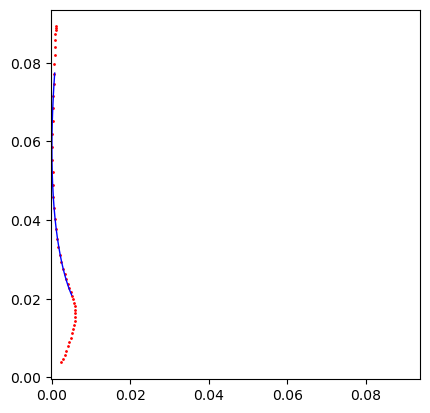

In [21]:
plt.scatter(np.real(results),
            np.imag(results), 
            color='r', s=1)
plt.plot(np.real(result.best_fit),
         np.imag(result.best_fit),
         linewidth=1, color='b')
plt.axis("square")
plt.show()

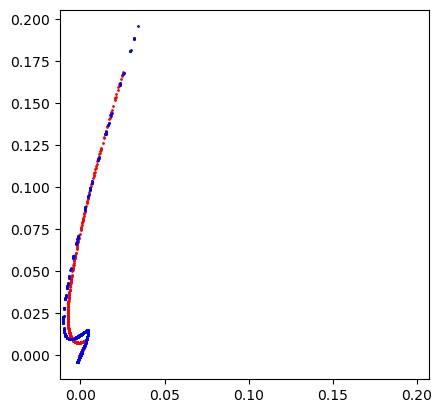

In [22]:
plt.scatter(np.real(components), np.imag(components), s=1, color='r')
plt.scatter(np.real(components_fit), np.imag(components_fit), s=1, color='b')
plt.axis('square')
plt.show()

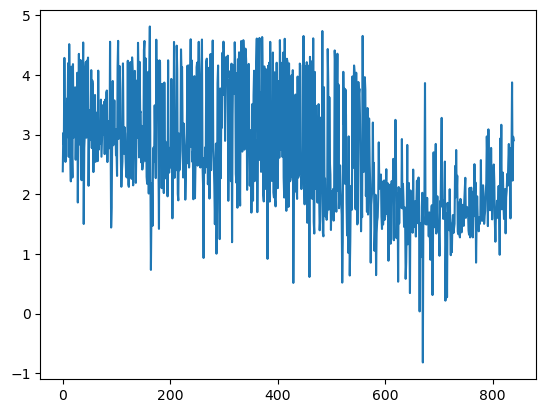

In [26]:
plt.plot(coeff_rec[:,2])
plt.show()